# Example use of the Sonic module Nodosus.jl

* https://juliadb.org
* https://julialang.org
* https://juliastats.org

In [98]:
import Pkg                      # package manager
Pkg.activate("..")              # Project.toml
Pkg.instantiate()               # https://julialang.github.io/Pkg.jl/v1.0/index.html

Activating environment at `~/Documents/Calendar/Work/Noda/Code/Sonic.jl/Project.toml`


In [99]:
import Dates, JuliaDB, Random, StatsPlots

In [100]:
using StatsPlots
ENV["GKSwstype"] = "100"
gr(fmt = :png)

Plots.GRBackend()

In [101]:
include("../src/Linckii.jl")
include("../src/LinckiiSecrets.jl")
include("../src/Nodosus.jl")

Main.Nodosus

Get access token,

In [102]:
@time access = Linckii.get_access(LinckiiSecrets.keab)

  0.002083 seconds (409 allocations: 27.781 KiB)


(url = "https://canary.noda.se/~keab", key = "e86d93131e6bc12ae701d036e696cf8b")

Load site,

In [103]:
@time site = Linckii.loadsite(access, :nodes, :devices, :sensors)
()

 19.537078 seconds (17.45 M allocations: 1.260 GiB, 4.03% gc time)


()

In [104]:
device_name = Linckii.get_cref(site.devices, :device_id, :device_name)
device_id   = Linckii.get_cref(site.devices, :device_name, :device_id)
()

()

In [105]:
sensor_name = Linckii.get_cref(site.sensors, :sensor_id, :sensor_name)
sensor_id   = Linckii.get_cref(site.sensors, :sensor_name, :sensor_id)
()

()

Select data,

In [122]:
selected_sensor_names = Dict(
    device_id["Kelp-Basic"] => [
        :meter_effect,
        :meter_heatenergy,
        :meter_primreturntemp,
        :meter_primsupplytemp,
        :meter_volume,
        :meter_volumeflow,
        :outdoortemp,
        :outdoortemp_offset,
    ],
    device_id["Weather-Forecast"] => [
        :cloudiness,
        :outdoortemp,
        :wind_direction,
        :wind_speed,
    ],
)

Dict{Int64,Array{Symbol,1}} with 2 entries:
  4 => Symbol[:meter_effect, :meter_heatenergy, :meter_primreturntemp, :meter_p…
  6 => Symbol[:cloudiness, :outdoortemp, :wind_direction, :wind_speed]

In [123]:
selected_nodes = JuliaDB.filter(
    r -> (
        r.device_id in keys(selected_sensor_names) &&
        Set(sensor_name[r_sensor_id] for r_sensor_id in r.sensor_ids) >= Set(selected_sensor_names[r.device_id])
    ),
    site.nodes,
)

Table with 85 rows, 8 columns:
Columns:
#  colname           type
─────────────────────────────────
1  node_public       Bool
2  node_name         String
3  device_id         Int64
4  node_id           Int64
5  node_owner        Bool
6  node_enabled      Bool
7  sensor_ids        Array{Any,1}
8  node_description  String

Save data,

In [110]:
p, q = Dates.Minute(10), Dates.Minute(120)
pp = Dict(
    :meter_effect           => t -> Nodosus.pp1(t, p, q),
    :meter_heatenergy       => t -> Nodosus.pp2(t, p, q),
    :meter_primreturntemp   => t -> Nodosus.pp1(t, p, q),
    :meter_primsupplytemp   => t -> Nodosus.pp1(t, p, q),
    :meter_volume           => t -> Nodosus.pp2(t, p, q),
    :meter_volumeflow       => t -> Nodosus.pp1(t, p, q),
    :outdoortemp            => t -> Nodosus.pp1(t, p, q),
    :outdoortemp_offset     => t -> Nodosus.pp0(t, p, q),
    :cloudiness             => t -> Nodosus.pp1(t, p, q),
    :outdoortemp            => t -> Nodosus.pp1(t, p, q),
    :wind_direction         => t -> Nodosus.pp1(t, p, q),
    :wind_speed             => t -> Nodosus.pp1(t, p, q),
)
()

()

In [116]:
rs = JuliaDB.rows(selected_nodes)
if true
    rs = [(node_id = 93, device_id = 4)] # [rs[Random.rand(1 : end)]]
end
@time for r in rs
    filepath = "$(Linckii.datapath(access, r.node_id)).db"
    try
        data = foldl(
            (l, r) -> JuliaDB.join(l, r; how = :outer),
            [
                JuliaDB.unstack(
                    pp[r_sensor_name](
                        Linckii.loaddata(access, r.node_id, r_sensor_name),
                    ),
                )
                for r_sensor_name in selected_sensor_names[r.device_id]
            ],
        )
        JuliaDB.save(
            data,
            "$(Linckii.datapath(access, r.node_id)).db",
        )
        println("$(filepath): Done")
    catch e
        println("$(filepath): $(e)")
    end
end

db/linckii/~keab/data/93.db: Done
  7.030931 seconds (61.95 M allocations: 1.764 GiB, 20.67% gc time)


Load data,

In [120]:
r = JuliaDB.rows(selected_nodes)[Random.rand(1 : end)]
r_node_id, r_device_id = 93, 4 # r.node_id, r.device_id

(93, 4)

In [124]:
r_sensor_names = selected_sensor_names[r_device_id]

8-element Array{Symbol,1}:
 :meter_effect        
 :meter_heatenergy    
 :meter_primreturntemp
 :meter_primsupplytemp
 :meter_volume        
 :meter_volumeflow    
 :outdoortemp         
 :outdoortemp_offset  

In [125]:
@time data = JuliaDB.load(
    "$(Linckii.datapath(access, r.node_id)).db",
)

  0.135897 seconds (1.18 M allocations: 24.391 MiB, 12.07% gc time)


Table with 84612 rows, 9 columns:
Columns:
#  colname               type
────────────────────────────────────────────────
1  datetime              DateTime
2  meter_primreturntemp  Union{Missing, Float64}
3  meter_effect          Union{Missing, Float64}
4  outdoortemp           Union{Missing, Float64}
5  meter_primsupplytemp  Union{Missing, Float64}
6  meter_volumeflow      Union{Missing, Float64}
7  meter_volume          Union{Missing, Float64}
8  outdoortemp_offset    Union{Missing, Float64}
9  meter_heatenergy      Union{Missing, Float64}

Complex plot,

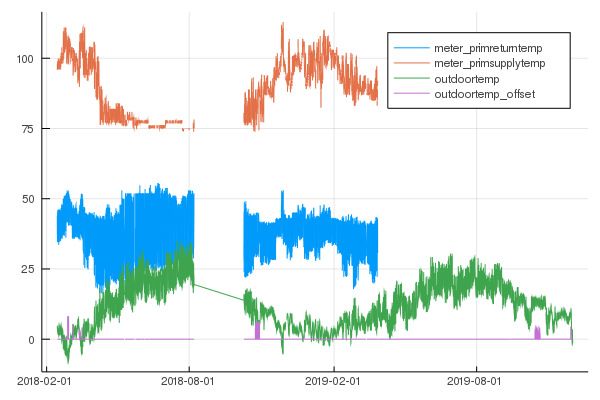

In [141]:
@df data plot(:datetime, [:meter_primreturntemp :meter_primsupplytemp :outdoortemp :outdoortemp_offset])